## Bayesian Inference - Trajectory Estimation with Noisy Measurements
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize

* We want to estimate <code>theta_0</code> and <code>theta_1</code>, which are unknown to us.
* The function <code>actual</code> captures the true trajectory, so we can benchmark how good our estimations are.

In [2]:
# unknown parameters which we have to estimate
theta_0 = {'loc': 200, 'scale': 50}
theta_1 = {'loc': 50, 'scale': 50}

def actual(t, height=theta_0['loc'], velo=theta_1['loc']):
    return height + velo*t + -9.81*t**2

In [3]:
# fixed time steps to plot trajectory
t_end = 12
t_time = pd.Series(np.arange(1, t_end+1))

# generate true line
Y = t_time.apply(actual)
Y.head()

0    240.19
1    260.76
2    261.71
3    243.04
4    204.75
dtype: float64

* We generate data via the <code>observed</code> function, which also includes a noise term.
* We generate random points in time in <code>t_obs</code> and apply the <code>observed</code> function with this array of timestamps and random draws from the normal distributions of <code>theta_0</code>, <code>theta_1</code>.

In [4]:
def normal(**kwargs):
    return np.random.normal(**kwargs)

def observed(t, height, velo, noise):
    return height + velo*t + -9.81*t**2 + noise

# noise in observations
W = {'loc': 0, 'scale': 50}

# number of observations
n_obs = 20
# timestamps of records
t_obs = np.random.randint(low=1, high=t_end, size=n_obs)

In [5]:
# generate noisy observation data
X = [observed(
    t=t, 
    height=normal(**theta_0), 
    velo=normal(**theta_1),  
    noise=normal(**W)) 
for t in t_obs]

X = pd.Series(data=X, index=t_obs)
X.head()

1    270.967903
2    335.477387
8    154.262961
1    136.787521
5    252.075592
dtype: float64

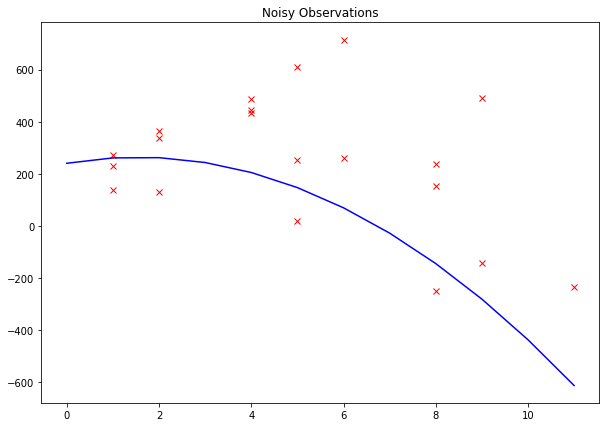

In [6]:
plt.figure(figsize=(10,7))
X.plot.line(color='r', lw=0, marker='x')
Y.plot.line(color='b')

plt.title('Noisy Observations')
plt.show()

* To find the <code>theta</code> values that maximize the PDFs, which is the same as minimizing the exponent. This is done with <code>func</code>, which takes in our prior believe and the data we have observed.
* We use <code>scipy.optimize</code> to find the respective values.

In [7]:
# prior believes about parameters
prior_0 = 300
prior_1 = 80

def func(THETA, X=X):
  """Function represents the exponent of posterior distribution. 
  To find the maximum posterior density, the exponent has to be minimized."""

  theta_0, theta_1 = THETA

  y = (theta_0 - prior_0)**2 + \
      (theta_1 - prior_1)**2 + \
      np.sum((X.values - theta_0 - theta_1 * X.index + 9.81 * X.index**2)**2)
  return y

In [8]:
THETA = [prior_0, prior_1]

result = optimize.minimize(func, THETA)
theta_hat_0, theta_hat_1 = result.x

print('Theta_0: ', round(theta_hat_0, 2))
print('Theta_1: ', round(theta_hat_1, 2))

print('Loss with prior beta: ', result.fun)
print('Loss with updated beta: ', func(THETA))

Theta_0:  215.76
Theta_1:  73.54
Loss with prior beta:  866737.7543147107
Loss with updated beta:  1154251.3350127025


* Now that we know <code>theta_hat_0</code> <code>theta_hat_1</code>, we can inpute them into the trajectory formula.
* With <code>.apply</code>, we can execute a function on an array, with addtional arguments of <code>height</code> and <code>velo</code>.

In [9]:
map_estimate = t_time.apply(
    actual, 
    height=theta_hat_0, 
    velo=theta_hat_1
)

prior_estimate = t_time.apply(
    actual, 
    height=prior_0, 
    velo=prior_1
)

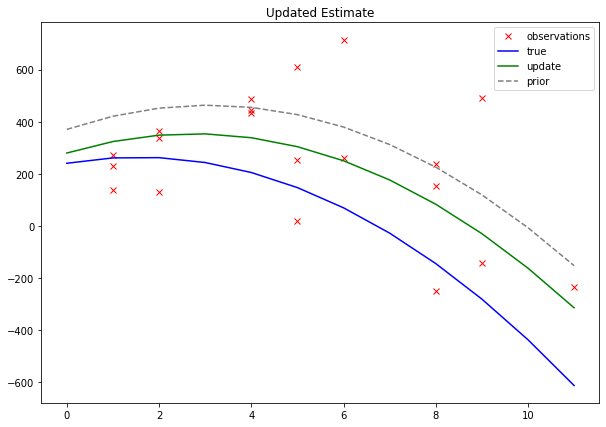

In [10]:
plt.figure(figsize=(10,7))
X.plot.line(color='r', lw=0, marker='x', label='observations')
Y.plot.line(color='b', label='true')

map_estimate.plot.line(color='g', label='update')
prior_estimate.plot.line(color='grey', ls='--', label='prior')

plt.legend()
plt.title('Updated Estimate')
plt.show()